In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

## Exploratory data analysis

In [2]:
pingwiny = pd.read_csv('penguins.csv')
pingwiny

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,NaN,NaN,NaN,NaN,0
4,36.7,19.3,193.0,3450.0,0
...,...,...,...,...,...
339,55.8,19.8,207.0,4000.0,2
340,43.5,18.1,202.0,3400.0,2
341,49.6,18.2,193.0,3775.0,2
342,50.8,19.0,210.0,4100.0,2


In [3]:
pingwiny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CulmenLength   342 non-null    float64
 1   CulmenDepth    342 non-null    float64
 2   FlipperLength  342 non-null    float64
 3   BodyMass       342 non-null    float64
 4   Species        344 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 13.6 KB


In [4]:
pingwiny.isnull().sum()

CulmenLength     2
CulmenDepth      2
FlipperLength    2
BodyMass         2
Species          0
dtype: int64

### Comment:
The above two observations have no data, only a species number. I have three choices: 1)leave it as it is, 2)delete these rows or 3)complete them (e.g. with average). I choose to remove them because, in my opinion, they contribute very little (they only indicate species) and may spoil the image of the model as outliers. These are two observations out of 344 - so they contribute little to the total data.

In [5]:
pingwiny.dropna(inplace = True)

In [6]:
features = ['CulmenLength','CulmenDepth','FlipperLength','BodyMass']

target = 'Species'
X, y = pingwiny[features], pingwiny[target]
print('X:')
display(X)
print('\ny:')
display(y)

X:


,CulmenLength,CulmenDepth,FlipperLength,BodyMass
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0
...,...,...,...,...
339,55.8,19.8,207.0,4000.0
340,43.5,18.1,202.0,3400.0
341,49.6,18.2,193.0,3775.0
342,50.8,19.0,210.0,4100.0



y:


0      0
1      0
2      0
4      0
5      0
      ..
339    2
340    2
341    2
342    2
343    2
Name: Species, Length: 342, dtype: int64

In [7]:
pd.Series(y).value_counts(normalize=True) #checking if classes are balanced. They are not.

0    0.441520
1    0.359649
2    0.198830
Name: Species, dtype: float64

In [8]:
X.describe()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


Unique values: 164


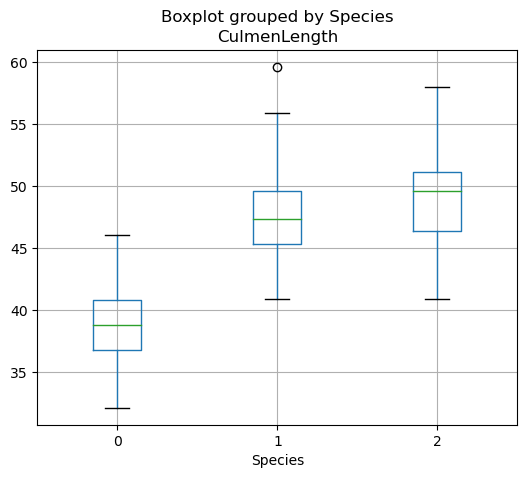

Unique values: 80


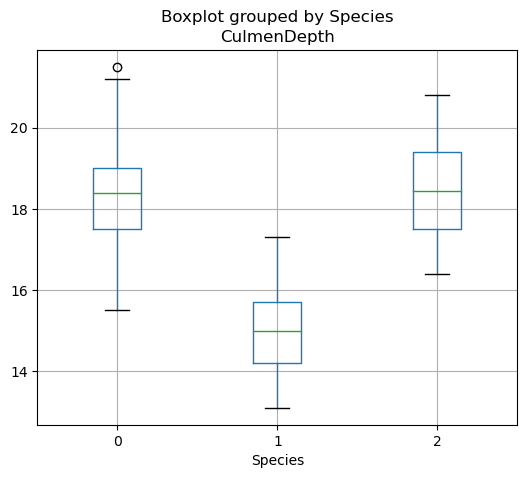

Unique values: 55


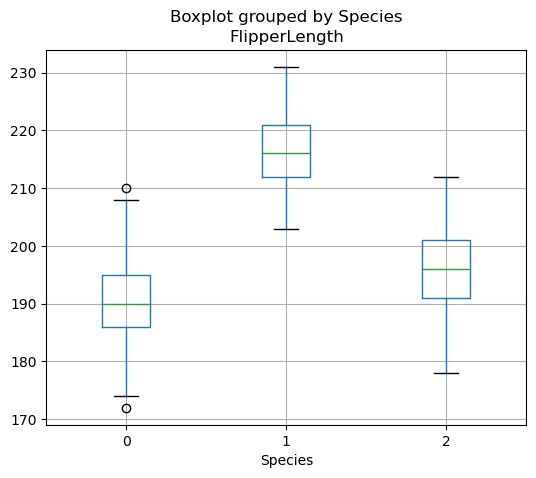

Unique values: 94


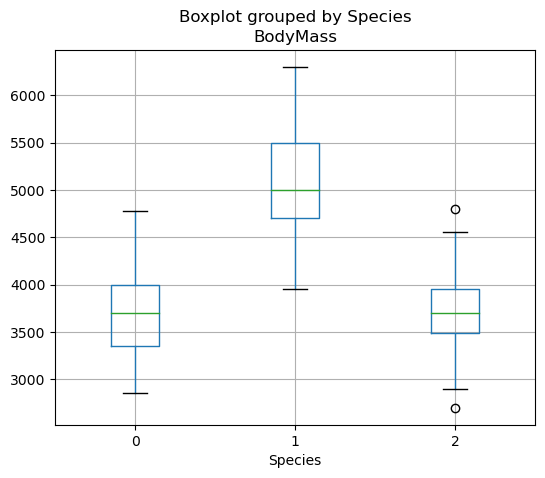

In [9]:
for col in features:
    print(f'Unique values: {len(pingwiny[col].unique())}')
    pingwiny.boxplot(column=col, by='Species', figsize=(6,5))
    plt.title(col)
    plt.show()

### Comment:
* CulmenLenght and FlipperLength best explain the division into genres, especially together.
* In the case of CulmenLenght, the values of species 1 and 2 are very close to each other.
Here the "FlipperLength" feature will come helpful, for which the values of the feature for class 1 and 2 are very different (while the values for species 0 and 2 are similar).
* Sometimes the values of some features within species overlap: e.g. the "BodyMass" value of species 2 is included in species 0, but clearly separates them from species 1.

At the moment, I believe that all of these features should be used as part of model building.

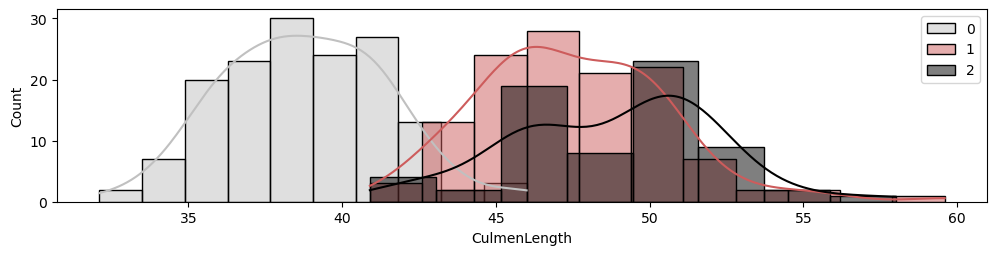

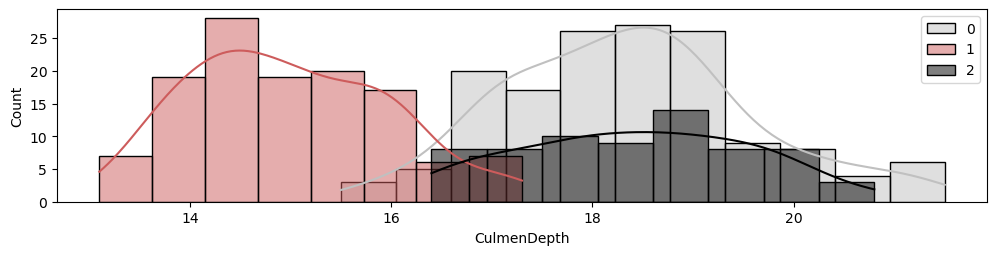

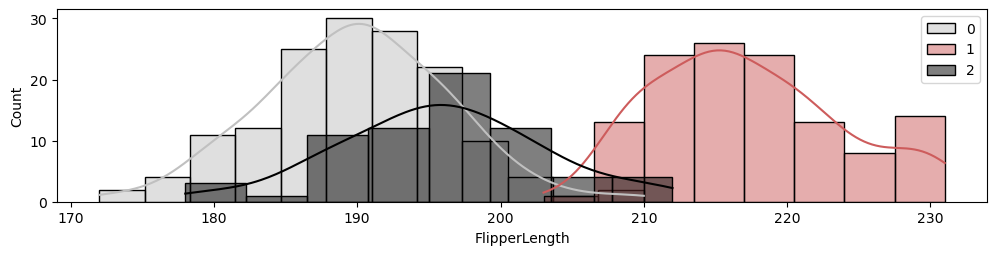

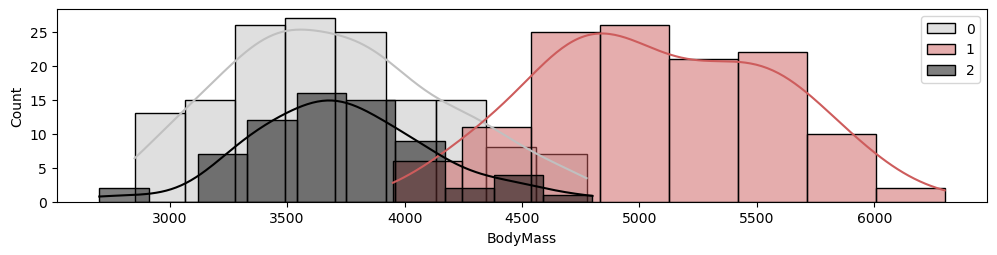

In [10]:
for col in features:
    plt.figure(figsize=(12, 2.5))
    sns.histplot(pingwiny.loc[pingwiny['Species']==0, col], kde=True, color='silver', label='0')
    sns.histplot(pingwiny.loc[pingwiny['Species']==1, col], kde=True, color='indianred', label='1')
    sns.histplot(pingwiny.loc[pingwiny['Species']==2, col], kde=True, color='black', label='2')
    plt.legend(loc='upper right')
    plt.show()

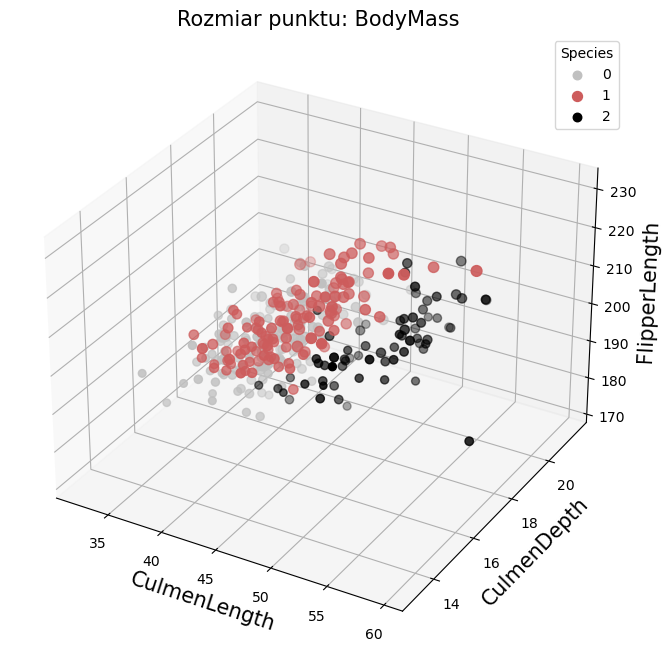

In [11]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(xs=pingwiny.loc[pingwiny['Species']== 0, 'CulmenLength'],
                 ys=pingwiny.loc[pingwiny['Species']==0,'CulmenDepth'],
                 zs=pingwiny.loc[pingwiny['Species']==0, 'FlipperLength'],
                 s=pingwiny.loc[pingwiny['Species']==0,'BodyMass']*0.01,
                 c='silver', label=0)
img = ax.scatter(xs=pingwiny.loc[pingwiny['Species']==1, 'CulmenLength'],
                 ys=pingwiny.loc[pingwiny['Species']==1,'CulmenDepth'],
                 zs=pingwiny.loc[pingwiny['Species']==1, 'FlipperLength'],
                 s=pingwiny.loc[pingwiny['Species']==1,'BodyMass']*0.01,
                 c='indianred', label=1)
img = ax.scatter(xs=pingwiny.loc[pingwiny['Species']==2, 'CulmenLength'],
                 ys=pingwiny.loc[pingwiny['Species']==2,'CulmenDepth'],
                 zs=pingwiny.loc[pingwiny['Species']==2, 'FlipperLength'],
                 s=pingwiny.loc[pingwiny['Species']==2,'BodyMass']*0.01,
                 c='black', label=2)
ax.set_xlabel(xlabel='CulmenLength', size=15)
ax.set_ylabel(ylabel='CulmenDepth', size=15)
ax.set_zlabel(zlabel='FlipperLength', size=15)
ax.set_title('Rozmiar punktu: BodyMass', size=15)
plt.legend(title='Species')
plt.show()

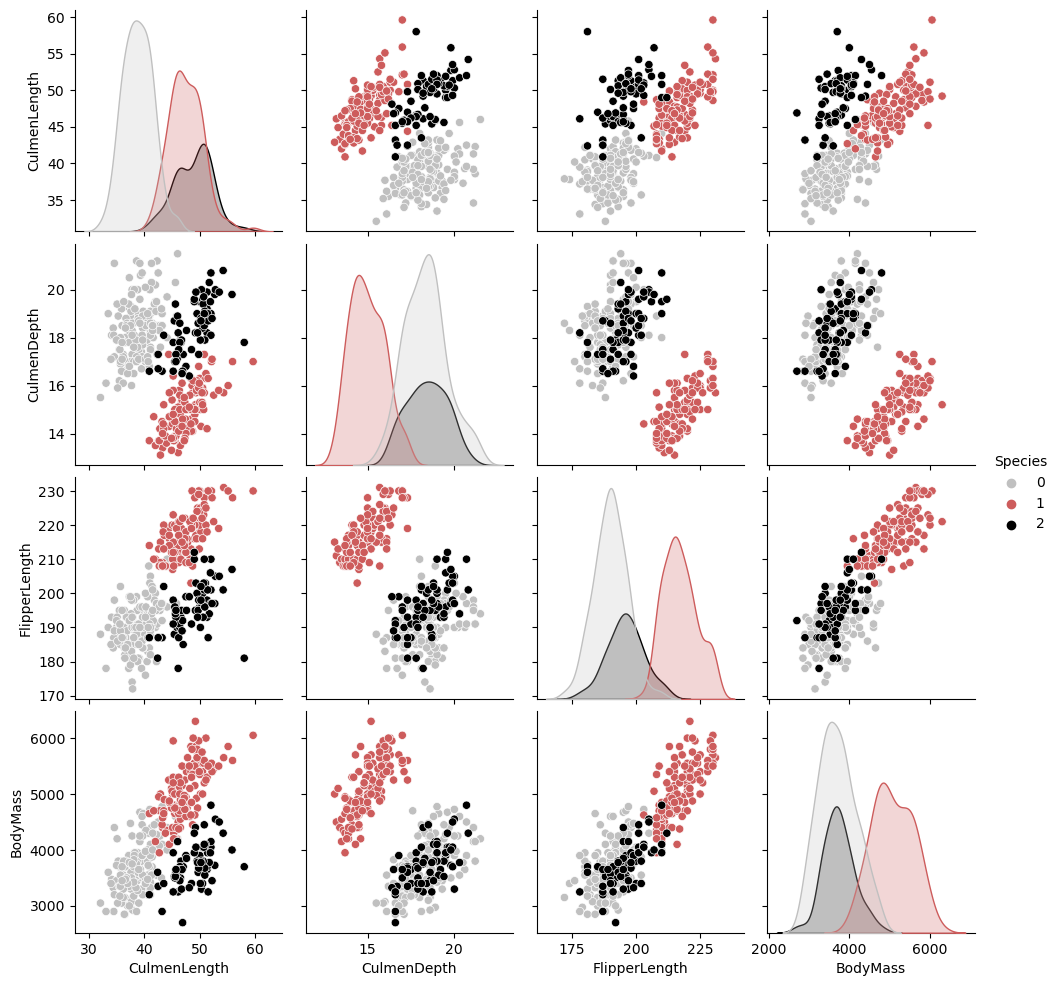

In [12]:
sns.pairplot(pingwiny,
             hue='Species',
             palette={0: 'silver', 1: 'indianred', 2: 'black'})
plt.show()

### Comment:
The above charts confirmed my earlier conclusions. In some characteristics, the classes overlap. However, within different features - pairs of features with overlapping values are different (sometimes classes 0 and 2 overlap, sometimes classes 1 and 2).

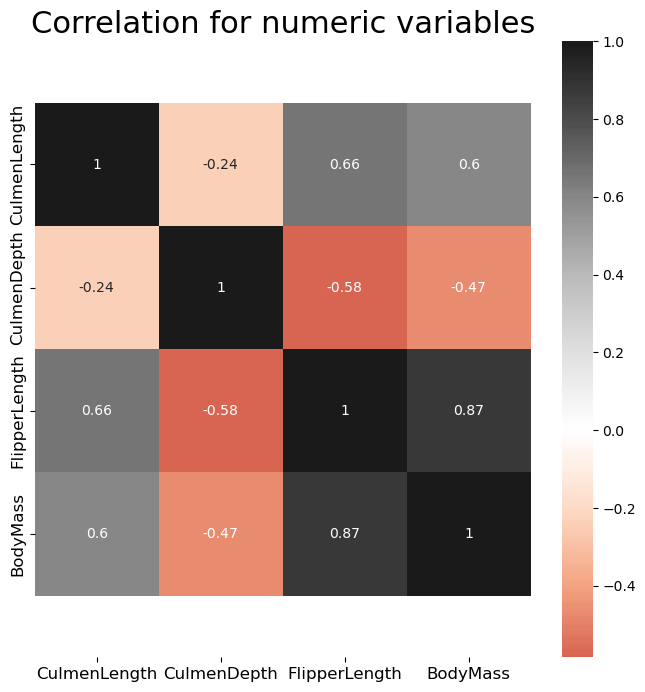

In [13]:
plt.figure(figsize=(8, 8))
ax = sns.heatmap(X.corr(),
                 xticklabels=X.corr().columns,
                 yticklabels=X.corr().columns,
                 cmap='RdGy',
                 center=0,
                 annot=True)

plt.title('Correlation for numeric variables', fontsize=22)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Comment:
The values are highly correlated (CulmenDepth negative with BodyMass and FlipperLength) or very strongly correlated (FlipperLength positive with BodyMass). For now, I leave everything as it is and see what comes of it.

In [14]:
corr_dict = {}
for col in features:
    corr_dict[col] = stats.pointbiserialr(X[col], y)[0]
pd.Series(corr_dict).sort_values(ascending=False)

CulmenLength     0.779857
FlipperLength    0.357472
BodyMass         0.209717
CulmenDepth     -0.183090
dtype: float64

### Comment:
Species affiliation is most dependent on CulmenLength.

# Train-Test split . Data standardization.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)
print ('Training observations: %d\nTest observations: %d' % (X_train.shape[0], X_test.shape[0]))

scaler_2var = StandardScaler()
X_train_standardized = scaler_2var.fit_transform(X_train)
X_test_standardized = scaler_2var.transform(X_test)

Training observations: 239
Test observations: 103


# Create a metrics_dataframe to check metrics

In [16]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'F1_score train', 'AUC','Accuracy','Precision','Recall'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []
def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    if np.all(X_checked == X_test):
        predictions_train = model.predict(X_train)
    else:
        predictions_train = model.predict(X_train_standardized)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Greys', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1],color = 'indianred', linestyle = '--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba, pos_label=1)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions, average = 'weighted')
    f1_metric_train = f1_score(y_train, predictions_train, average = 'weighted')
    accuracy_metric = accuracy_score(y_test, predictions)
    precision_metric = precision_score(y_test, predictions, average = 'weighted')
    recall_metric = recall_score(y_test, predictions, average = 'weighted')
    auc_metric = roc_auc_score(y_checked, predictions_proba, multi_class = 'ovo')    
    metrics_dataframe = pd.concat([metrics_dataframe, pd.DataFrame.from_records([{ 'Model': name, 'F1_score': f1_metric, 'F1_score train': f1_metric_train, 'AUC': auc_metric,'Accuracy': accuracy_metric, 'Precision': precision_metric,'Recall': recall_metric }])])

# MODEL TRAINING

## Logistic Regression

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           1       1.00      1.00      1.00        37
           2       0.95      0.90      0.93        21

    accuracy                           0.97       103
   macro avg       0.97      0.96      0.96       103
weighted avg       0.97      0.97      0.97       103



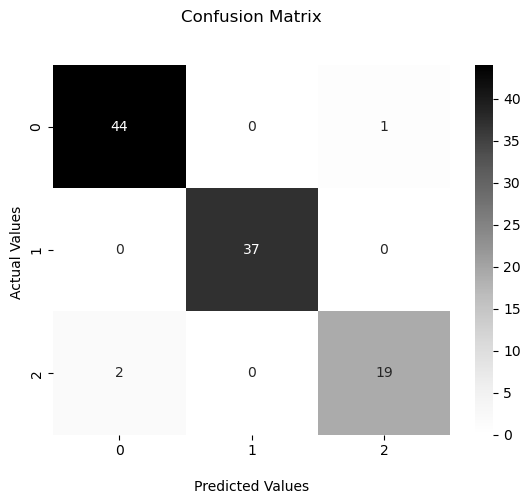

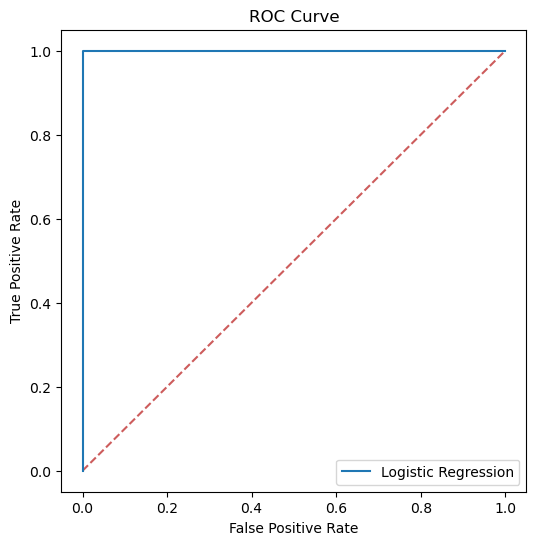

In [17]:
model_lr = LogisticRegression()
model_lr.fit(X_train_standardized, y_train)

calculate_metrics(model_lr, 'Logistic Regression', X_test_standardized, y_test)

### Comment:
The model is great. Training F1 (=1) could indicate overtraining of the model - if not for the fact that the test F1 is close to this ideal, i.e. it is 0.98. This can be used to reduce the share of training data (we don't always have access to a large database, and effective modeling based on a smaller sample is, I suspect, valuable). I'm checking how changing test_size from 0.3 to ...0.9 will affect the model.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=0,  stratify=y)
print ('Training observations: %d\nTest observations: %d' % (X_train.shape[0], X_test.shape[0]))

scaler_2var = StandardScaler()
X_train_standardized = scaler_2var.fit_transform(X_train)
X_test_standardized = scaler_2var.transform(X_test)


metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'F1_score train', 'AUC','Accuracy','Precision','Recall'])
models = []
models_names = []
predictions_proba_list = []

Training observations: 34
Test observations: 308


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       136
           1       1.00      1.00      1.00       111
           2       0.98      0.97      0.98        61

    accuracy                           0.99       308
   macro avg       0.99      0.99      0.99       308
weighted avg       0.99      0.99      0.99       308



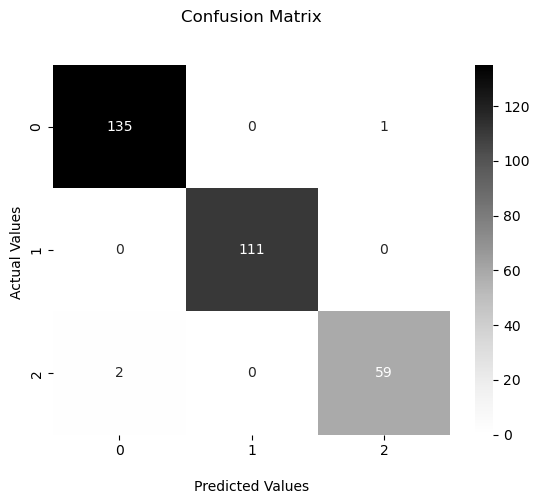

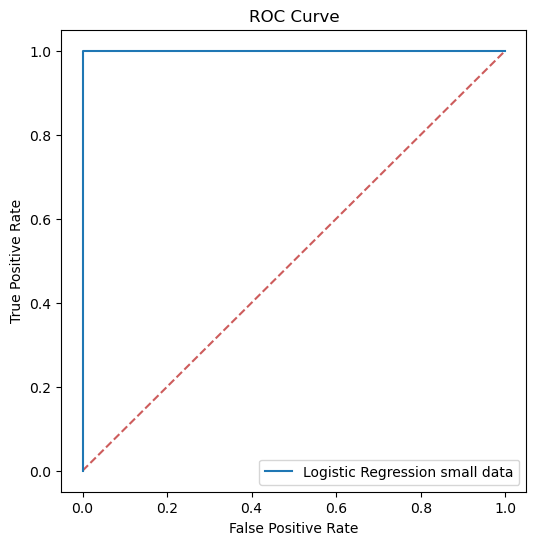

In [19]:
model_lr_small_data = LogisticRegression()
model_lr_small_data.fit(X_train_standardized, y_train)

calculate_metrics(model_lr_small_data, 'Logistic Regression small data', X_test_standardized, y_test)

### Comment:
The result is great.

I remember that the features are correlated so they carry the same information. Of the four, I will discard two and leave the ones that bring the most information. I will repeat the data splitting process (leaving test_size=0.9).

In [20]:
features = ['CulmenLength', 'FlipperLength']
target = 'Species'
X, y = pingwiny[features], pingwiny[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=0,  stratify=y)
print ('Training observations: %d\nTest observations: %d' % (X_train.shape[0], X_test.shape[0]))

scaler_2var = StandardScaler()
X_train_standardized = scaler_2var.fit_transform(X_train)
X_test_standardized = scaler_2var.transform(X_test)

Training observations: 34
Test observations: 308



Best hyperparameter: {'max_iter': 100, 'solver': 'lbfgs'}
z KMeans : 0.9545454545454546
bez KMeans : 0.9512987012987013
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       136
           1       0.96      0.99      0.97       111
           2       0.90      0.89      0.89        61

    accuracy                           0.95       308
   macro avg       0.94      0.94      0.94       308
weighted avg       0.95      0.95      0.95       308



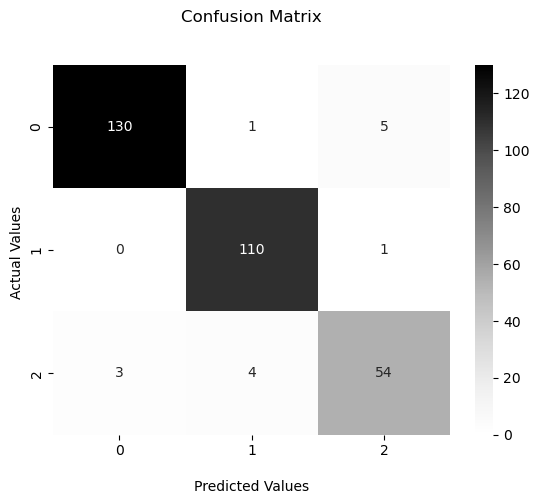

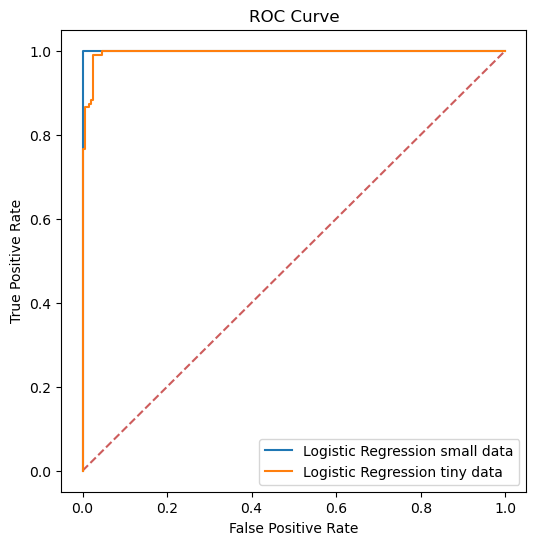

In [21]:
model_lr_tiny_data = LogisticRegression()
model_lr_tiny_data.fit(X_train_standardized, y_train)


params_lr = {
             'solver' : ['lbfgs', 'newton-cg','sag','saga'],
             'max_iter' : [100,1000,10000],
             }
lr_gridsearch = GridSearchCV(model_lr_tiny_data,
                             params_lr,
                             scoring='f1_weighted')
lr_gridsearch.fit(X_train_standardized, y_train)
print('\nBest hyperparameter:', lr_gridsearch.best_params_)
model_lr_grid = lr_gridsearch.best_estimator_

pipeline_lr = Pipeline([
    ("kmeans", KMeans(n_clusters=20, random_state=2)),
    ("log_reg", model_lr_grid),
])
pipeline_lr.fit(X_train_standardized, y_train)
print("z KMeans :", pipeline_lr.score(X_test_standardized, y_test))
print("bez KMeans :", model_lr_tiny_data.score(X_test_standardized, y_test))


calculate_metrics(pipeline_lr, 'Logistic Regression tiny data', X_test_standardized, y_test)

### Comment:
Despite the significant reduction of test data - the model is still very good. He misclassified 15 out of 308 cases. So which model to choose? In this case, you can approach the subject in a business-like manner: calculate the costs of 15 misclassified cases and compare them to the cost of obtaining data. For the purpose of this task (and for the adventure), I consider that we want to train the model with less data (chasing penguins and measuring them can be an expensive endeavor).

From now on, I will train models based on two features: 'CulmenLength' and 'FlipperLength', and there are 34 training observations.

## K Nearest Neighbours

While training KNeighborsClassifier() a FutureWarning occurs:

"FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted."

FutureWarning messages are designed to inform about upcoming changes to default values for arguments in the scikit-learn API.
FutureWarning messages can be ignored or suppressed as they do not halt the execution of your program.

In [22]:
from warnings import simplefilter, resetwarnings
simplefilter(action='ignore', category=FutureWarning)


Best hyperparameter: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 2, 'weights': 'distance'}
z KMeans : 0.9545454545454546
bez KMeans : 0.948051948051948
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       136
           1       0.96      0.99      0.97       111
           2       0.85      0.92      0.88        61

    accuracy                           0.95       308
   macro avg       0.93      0.95      0.94       308
weighted avg       0.95      0.95      0.95       308



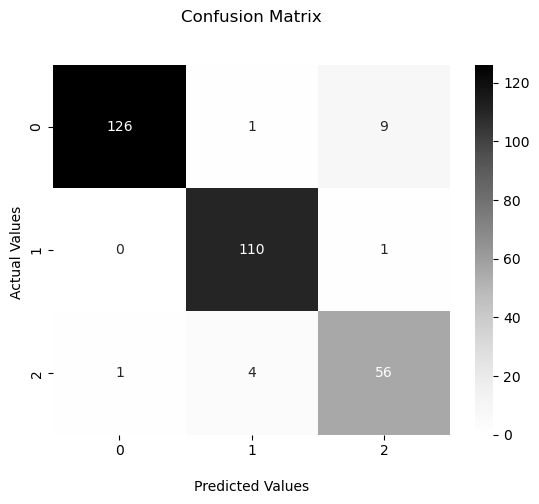

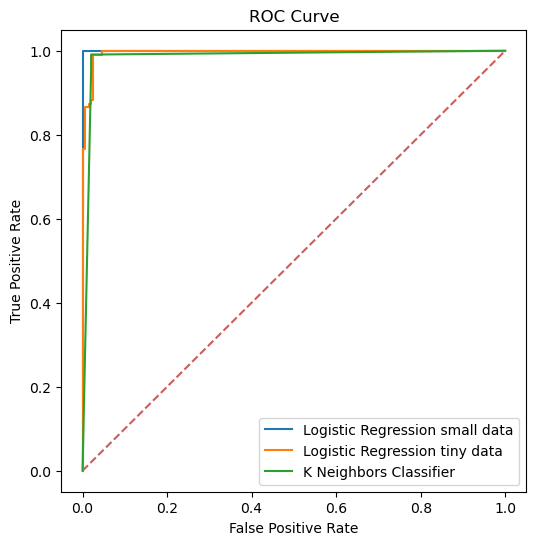

In [23]:
model_knn = KNeighborsClassifier()
params_knn = {'n_neighbors': [2, 3, 5, 10],
             'weights' : ['uniform', 'distance'],
             'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
             'leaf_size' : [10,30,50,100],
             }
knn_gridsearch = GridSearchCV(model_knn,
                             params_knn,
                             scoring='f1_weighted')
knn_gridsearch.fit(X_train_standardized, y_train)
print('\nBest hyperparameter:', knn_gridsearch.best_params_)
model_knn_grid = knn_gridsearch.best_estimator_


pipeline_knn = Pipeline([
    ("kmeans", KMeans(n_clusters=20, random_state=2)),
    ("knn", model_lr_grid),
])
pipeline_knn.fit(X_train_standardized, y_train)
print("z KMeans :", pipeline_knn.score(X_test_standardized, y_test))
print("bez KMeans :", model_knn_grid.score(X_test_standardized, y_test))

calculate_metrics(model_knn_grid, 'K Neighbors Classifier', X_test_standardized, y_test)

resetwarnings()

## Decision Tree

Fitting 5 folds for each of 64 candidates, totalling 320 fits

Best hyperparameter: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3, 'splitter': 'best'}
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       136
           1       0.94      0.99      0.96       111
           2       0.76      0.90      0.83        61

    accuracy                           0.92       308
   macro avg       0.90      0.92      0.91       308
weighted avg       0.93      0.92      0.92       308



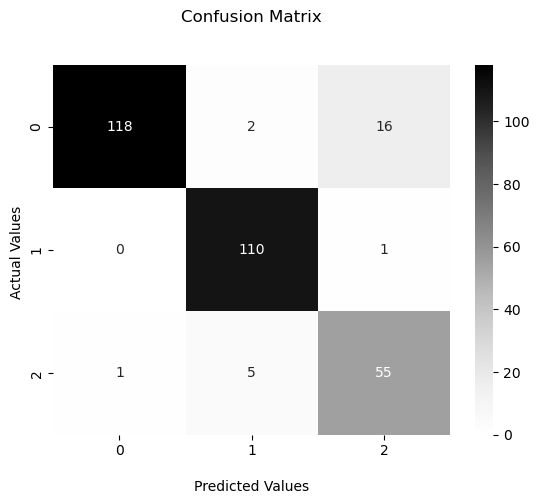

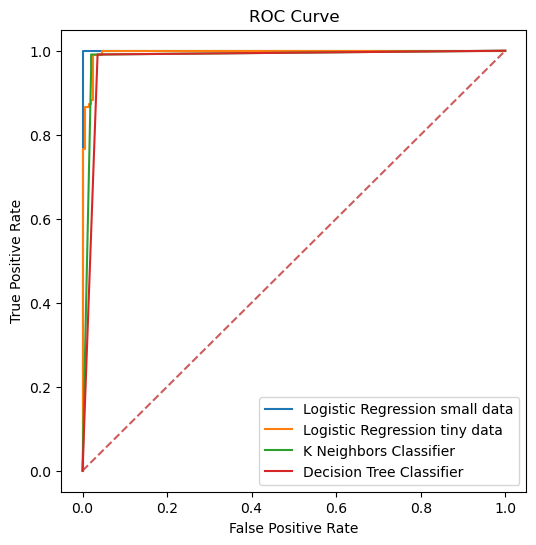

In [24]:
model_tree = DecisionTreeClassifier()
params_tree = {
               'criterion' : ['gini','entropy'],
               'splitter' : ['best', 'random'],
               'max_depth': [2, 3, 5, 10],
               'min_samples_leaf': [3, 5, 10, 15]}
tree_gridsearch = GridSearchCV(model_tree,
                               params_tree,
                               scoring='f1_weighted',
                               cv=5,
                               verbose=10, n_jobs=-1)
tree_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', tree_gridsearch.best_params_)
model_tree_grid = tree_gridsearch.best_estimator_

calculate_metrics(model_tree_grid, 'Decision Tree Classifier', X_test, y_test)

## SVM (Support Vector Machines)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best hyperparameter: {'C': 0.3, 'degree': 2, 'kernel': 'sigmoid'}
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       136
           1       0.90      1.00      0.94       111
           2       0.94      0.72      0.81        61

    accuracy                           0.93       308
   macro avg       0.93      0.90      0.91       308
weighted avg       0.93      0.93      0.93       308



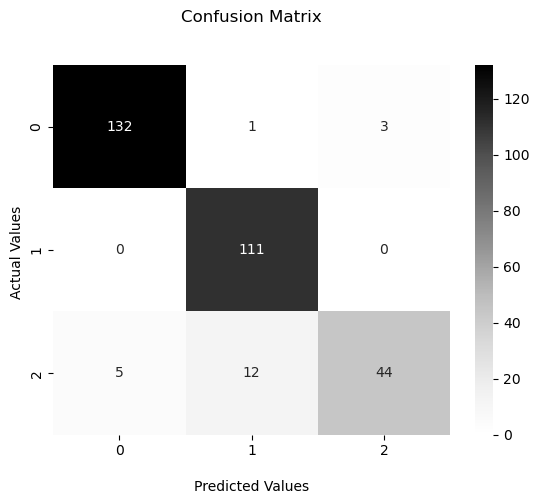

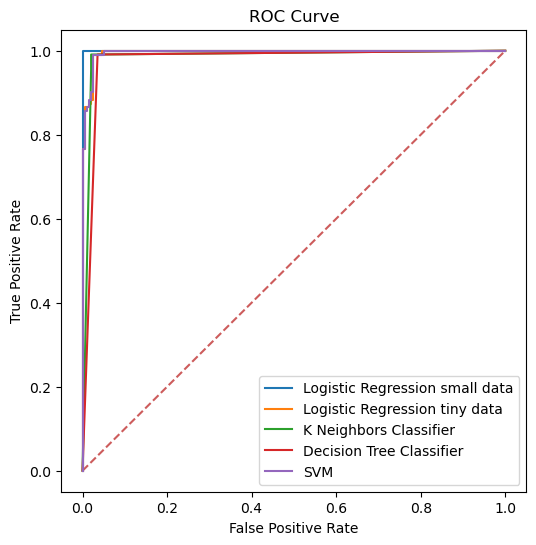

In [25]:
model_svm = SVC(probability=True)
params_svm = {'C' : [0.1, 0.3, 0.5, 0.7,1.0],
              'kernel' : ['linear', 'poly','rbf','sigmoid'],
              'degree' : [2,3,4]
             }
svm_gridsearch = GridSearchCV(model_svm,
                             params_svm,
                             scoring='f1_weighted',
                             cv=5,
                             verbose=10, n_jobs=-1)
svm_gridsearch.fit(X_train_standardized, y_train)
print('\nBest hyperparameter:', svm_gridsearch.best_params_)
model_svm_grid = svm_gridsearch.best_estimator_

calculate_metrics(model_svm_grid, 'SVM', X_test_standardized, y_test)

## Random Forest

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best hyperparameter: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 500}
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       136
           1       0.95      0.97      0.96       111
           2       0.88      0.87      0.88        61

    accuracy                           0.94       308
   macro avg       0.93      0.93      0.93       308
weighted avg       0.94      0.94      0.94       308



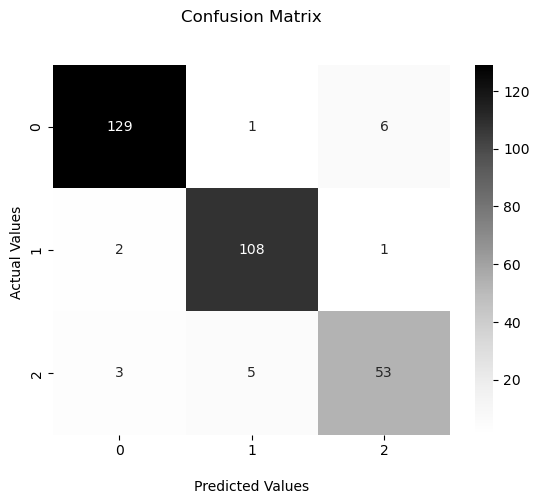

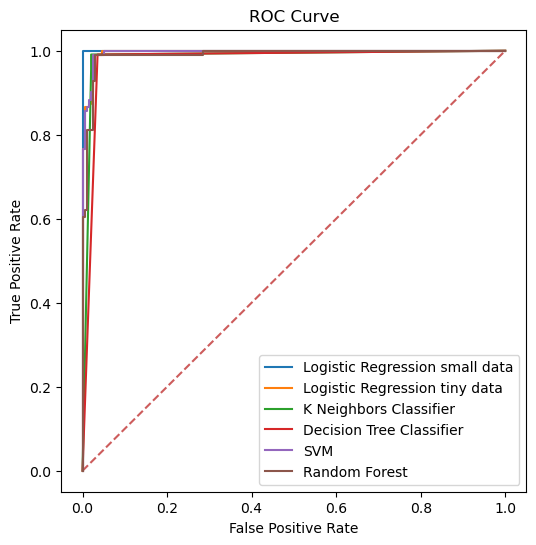

In [26]:
model_random_forest = RandomForestClassifier()
params_random_forest = {
    'n_estimators' : [500,1000,2000],
    'max_depth': [3, 5, 10],
    'min_samples_leaf': [3, 5, 10],
    'min_samples_split' : [2,3,4]
                }
random_forest_gridsearch = GridSearchCV(model_random_forest,
                             params_random_forest,
                             scoring='f1_weighted',
                             cv=5,
                             verbose=10, n_jobs=-1)
random_forest_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', random_forest_gridsearch.best_params_)
model_random_forest_grid = random_forest_gridsearch.best_estimator_

calculate_metrics(model_random_forest_grid, 'Random Forest', X_test, y_test)

## Boosting — AdaBoost

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       136
           1       0.94      0.99      0.96       111
           2       0.92      0.89      0.90        61

    accuracy                           0.95       308
   macro avg       0.95      0.94      0.95       308
weighted avg       0.95      0.95      0.95       308



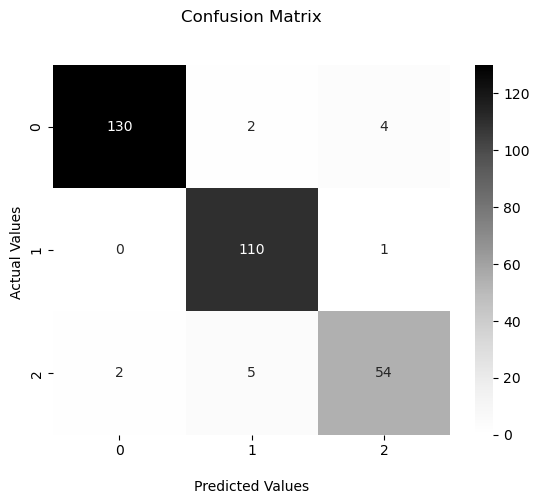

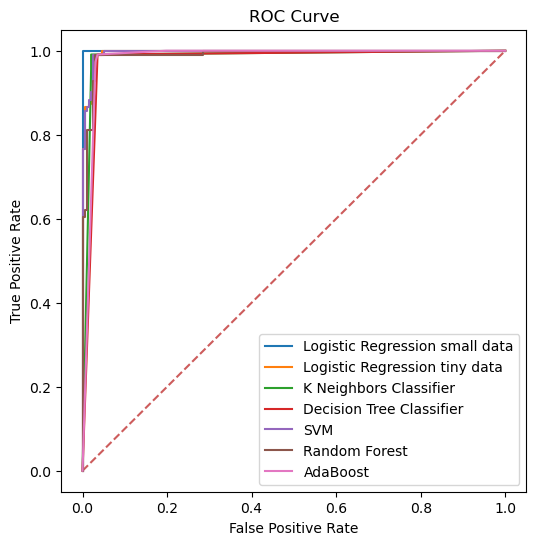

In [27]:
model_adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50)
model_adaboost.fit(X_train, y_train)

calculate_metrics(model_adaboost, 'AdaBoost', X_test, y_test)

## Voting

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       136
           1       0.94      0.99      0.96       111
           2       0.92      0.89      0.90        61

    accuracy                           0.95       308
   macro avg       0.95      0.94      0.95       308
weighted avg       0.95      0.95      0.95       308



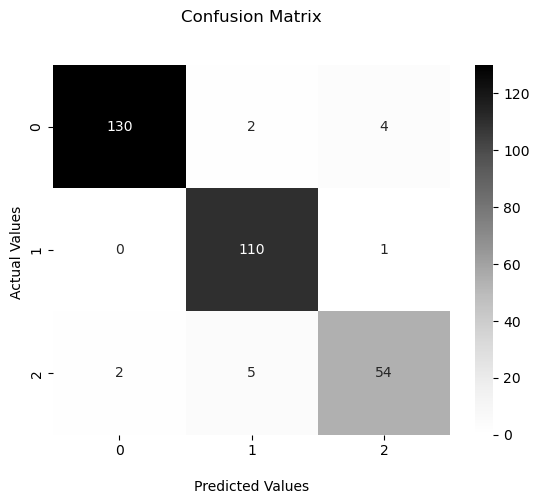

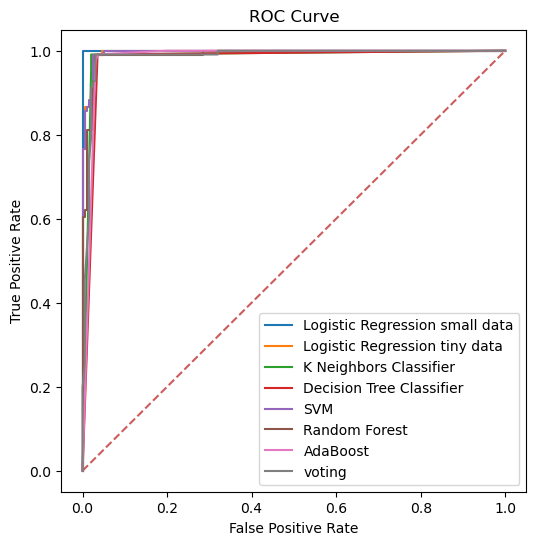

In [28]:
model_tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=3)
model_forest = RandomForestClassifier(n_estimators=1000, max_depth=3, min_samples_leaf= 3)

model_voting = VotingClassifier(estimators=[('Tree', model_tree),
                                            ('Random Forest', model_random_forest),
                                            ('AdaBoost', model_adaboost)],
                                voting='soft')
model_voting.fit(X_train, y_train)

calculate_metrics(model_voting, 'voting', X_test, y_test)

In [29]:
metrics_dataframe

,Model,F1_score,F1_score train,AUC,Accuracy,Precision,Recall
0,Logistic Regression small data,0.990237,0.969931,0.999578,0.990260,0.990253,0.990260
0,Logistic Regression tiny data,0.954380,0.969931,0.990876,0.954545,0.954566,0.954545
0,K Neighbors Classifier,0.948572,1.000000,0.972363,0.948052,0.950846,0.948052
0,Decision Tree Classifier,0.920205,0.971062,0.949473,0.918831,0.927965,0.918831
0,SVM,0.928830,0.969931,0.990927,0.931818,0.933460,0.931818
0,Random Forest,0.941408,0.969931,0.980322,0.941558,0.941450,0.941558
0,AdaBoost,0.954369,1.000000,0.961241,0.954545,0.954964,0.954545
0,voting,0.954369,1.000000,0.978055,0.954545,0.954964,0.954545


# Conclusion:

As for such a small amount of training data (34 observations with two features), the classification proceeded well.
I consider all models to be good, none have been overtrained. The Voting and Adaboost models trained best (F1 for test =0.954). They misclassified 14 out of 342 observations (4% of all observations). Not much behind them is the logistic regression model.
The tree model had the most incorrectly assigned observations and it was 25 errors out of 342 of all observations (which is 7% of all observations).